## Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic

Basically, we only need the context and stream

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
import pycuda.driver as cuda
gpu_stream = cuda.Stream()

# Sampling GRF: FFT Approach

Use GPU for sampling random numbers (first step of immense speed-up)

In [5]:
nx = 10#630
ny = 5#315

In [6]:
from gpuocean.utils import Common

random_numbers_host = np.zeros((nx,ny), dtype=np.float32, order='C')
random_numbers = Common.CUDAArray2D(gpu_stream, ny, nx, 0, 0, random_numbers_host)

In [7]:
from pycuda.curandom import XORWOWRandomNumberGenerator
rng = XORWOWRandomNumberGenerator()

In [8]:
rng.fill_normal(random_numbers.data, stream=gpu_stream)

In [9]:
u = random_numbers.download(gpu_stream).T

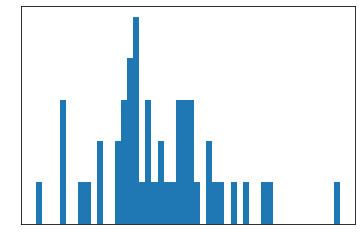

In [10]:
_ = plt.hist(u.flatten(), bins=50)

Only one row of distance matrix needed

In [11]:
dist = np.zeros((nx*ny))
for j in range(ny):
    for i in range(nx):
        dist[j*nx+i] = np.sqrt(i**2+j**2)
        dist[j*nx+i] = min([np.sqrt(i**2+j**2),np.sqrt((i-nx)**2+j**2),np.sqrt(i**2+(j-ny)**2),np.sqrt((i-nx)**2+(j-ny)**2)]) # only periodic!! Otherwise complex fft values!!

In [12]:
phi = 0.001
corr = np.exp(-phi*dist**2)

In [13]:
cov_toepitz = np.reshape(corr, (ny, nx))

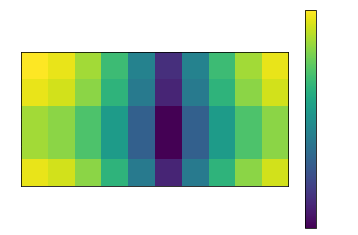

In [14]:
plt.imshow(cov_toepitz)
plt.colorbar()

#### FFT on the CPU

In [15]:
np.fft.fft2(cov_toepitz)

array([[ 4.94793232e+01+0.j,  2.58610377e-01+0.j, -7.06660663e-02+0.j,
         3.72264977e-02+0.j, -2.69205218e-02+0.j,  2.43460411e-02+0.j,
        -2.69205218e-02+0.j,  3.72264977e-02+0.j, -7.06660663e-02+0.j,
         2.58610377e-01+0.j],
       [ 5.79221811e-02+0.j,  3.02738117e-04+0.j, -8.27241043e-05+0.j,
         4.35786063e-05+0.j, -3.15140799e-05+0.j,  2.85003050e-05+0.j,
        -3.15140799e-05+0.j,  4.35786063e-05+0.j, -8.27241043e-05+0.j,
         3.02738117e-04+0.j],
       [-8.42804549e-03+0.j, -4.40503201e-05+0.j,  1.20368830e-05+0.j,
        -6.34096419e-06+0.j,  4.58549892e-06+0.j, -4.14697553e-06+0.j,
         4.58549892e-06+0.j, -6.34096419e-06+0.j,  1.20368830e-05+0.j,
        -4.40503201e-05+0.j],
       [-8.42804549e-03+0.j, -4.40503201e-05+0.j,  1.20368830e-05+0.j,
        -6.34096419e-06+0.j,  4.58549892e-06+0.j, -4.14697553e-06+0.j,
         4.58549892e-06+0.j, -6.34096419e-06+0.j,  1.20368830e-05+0.j,
        -4.40503201e-05+0.j],
       [ 5.79221811e-02+0.j,

In [16]:
cmf = np.real(np.fft.fft2(cov_toepitz))
uif = np.fft.ifft2(u)
xf = np.real(np.fft.fft2(np.sqrt(np.maximum(cmf,0))*uif))

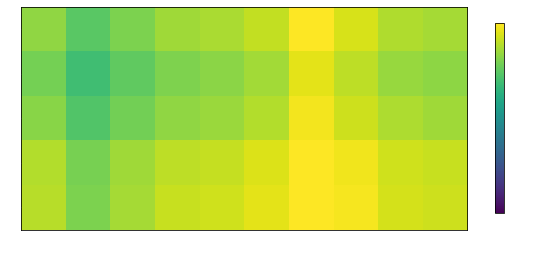

In [65]:
plt.figure(figsize=(10,5))
plt.imshow(xf, origin="lower", vmin=-1, vmax=1)
plt.colorbar(shrink=0.7)

#### FFT via skcuda (1D vs 2D?)

In [18]:
import numpy as np

import pycuda.driver as cuda
from pycuda.tools import make_default_context
import pycuda.gpuarray as gpuarray

In [19]:
from skcuda.fft import fft, ifft, Plan

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [66]:
# https://forums.developer.nvidia.com/t/how-to-apply-scikit-cuda-2d-fft-pycuda/33055

data = np.random.randn(4,4)
print(data)

data_gpu = gpuarray.to_gpu(data.astype(np.float32))
out_gpu = gpuarray.empty(data.shape, np.complex64)

plan = Plan(data.shape, np.complex64, np.complex64)
fft(data_gpu, out_gpu, plan)
ifft(out_gpu, data_gpu, plan)

print("It s a god damn shit!!! ")
data_gpu.get()/np.product(data.shape)

[[ 0.30166586 -0.24611511 -0.97885645  0.18860965]
 [ 0.12647603 -0.45502664 -0.75042047 -2.3035164 ]
 [ 1.16495721  0.411279   -0.4642364  -1.40743975]
 [ 0.29997652 -0.77321212 -0.15671613 -0.07538854]]
It s a god damn shit!!! 


array([[ 0.30166584, -0.24611515, -0.97885644,  0.1886096 ],
       [ 0.12647599, -0.4550267 , -0.75042045, -2.3035164 ],
       [ 1.1649573 ,  0.411279  , -0.46423644, -1.4074397 ],
       [ 0.2999766 , -0.7732122 , -0.15671623, -0.07538843]],
      dtype=float32)

In [71]:
# https://github.com/lebedov/scikit-cuda/issues/253
N = 4
array = np.random.randint(255, size=(N, N)).astype(np.float32)
print(array)
array_gpu = gpuarray.to_gpu(array)
ft = np.fft.fft2(array)
print(ft)

ft_gpu = gpuarray.empty((N//2+1, N//2+1), dtype=np.complex64)
plan = Plan((N, N), np.float32, np.complex64)
fft(array_gpu, ft_gpu, plan)
print(ft_gpu.get())


plan_inv = Plan((N, N), np.complex64, np.float32)
ifft(ft_gpu, array_gpu, plan_inv)
print(array)
print(array_gpu.get()/np.product(array_gpu.shape))

[[145. 221. 232. 106.]
 [ 10.  17. 144.  82.]
 [ 66.  83. 145.  68.]
 [143. 205.   2. 134.]]
[[1803.  +0.j -159.-136.j  -29.  +0.j -159.+136.j]
 [ 342.+231.j  128.+175.j  -10.-249.j -144.+375.j]
 [ 329.  +0.j -173.-124.j  249.  +0.j -173.+124.j]
 [ 342.-231.j -144.-375.j  -10.+249.j  128.-175.j]]
[[1803.  +0.j -159.-136.j  -29.  +0.j]
 [ 342.+231.j  128.+175.j  -10.-249.j]
 [ 329.  +0.j -173.-124.j  249.  +0.j]]
[[145. 221. 232. 106.]
 [ 10.  17. 144.  82.]
 [ 66.  83. 145.  68.]
 [143. 205.   2. 134.]]
[[145. 221. 232. 106.]
 [ 10.  17. 144.  82.]
 [ 66.  83. 145.  68.]
 [143. 205.   2. 134.]]


In [25]:
# is it 2D???

In [26]:
toep_gpu = gpuarray.to_gpu(cov_toepitz.astype(np.float32))
cmf_gpu = gpuarray.empty(np.array(toep_gpu.shape)//2+1, np.complex64)
plan = Plan(toep_gpu.shape, np.float32, np.complex64)
fft(toep_gpu, cmf_gpu, plan)

In [27]:
cmf, cmf_gpu.real

(array([[ 4.94793232e+01,  2.58610377e-01, -7.06660663e-02,
          3.72264977e-02, -2.69205218e-02,  2.43460411e-02,
         -2.69205218e-02,  3.72264977e-02, -7.06660663e-02,
          2.58610377e-01],
        [ 5.79221811e-02,  3.02738117e-04, -8.27241043e-05,
          4.35786063e-05, -3.15140799e-05,  2.85003050e-05,
         -3.15140799e-05,  4.35786063e-05, -8.27241043e-05,
          3.02738117e-04],
        [-8.42804549e-03, -4.40503201e-05,  1.20368830e-05,
         -6.34096419e-06,  4.58549892e-06, -4.14697553e-06,
          4.58549892e-06, -6.34096419e-06,  1.20368830e-05,
         -4.40503201e-05],
        [-8.42804549e-03, -4.40503201e-05,  1.20368830e-05,
         -6.34096419e-06,  4.58549892e-06, -4.14697553e-06,
          4.58549892e-06, -6.34096419e-06,  1.20368830e-05,
         -4.40503201e-05],
        [ 5.79221811e-02,  3.02738117e-04, -8.27241043e-05,
          4.35786063e-05, -3.15140799e-05,  2.85003050e-05,
         -3.15140799e-05,  4.35786063e-05, -8.272410

In [37]:
np.fft.ifft2(u)

array([[ 0.10765737+0.00000000e+00j, -0.11839945-1.19189077e-01j,
        -0.02387899+1.14167369e-01j,  0.09652482-1.50596020e-01j,
         0.02610289+1.28033850e-01j,  0.10959656+1.33226763e-17j,
         0.02610289-1.28033850e-01j,  0.09652482+1.50596020e-01j,
        -0.02387899-1.14167369e-01j, -0.11839945+1.19189077e-01j],
       [ 0.19425758+9.85641041e-02j, -0.01953117+2.89484201e-01j,
         0.0665797 -7.01741066e-02j, -0.01249381-6.27542119e-02j,
         0.08403675-1.42991545e-02j, -0.16832661+3.54313400e-02j,
         0.10244239-9.11201817e-02j,  0.02884003-7.49249337e-02j,
        -0.05362156-5.97139393e-02j,  0.07016676-7.39238952e-02j],
       [ 0.12763886-1.66771888e-01j, -0.07500304-2.91382225e-02j,
         0.11047469-1.19910110e-01j, -0.1060313 -3.25547352e-02j,
         0.00848348+1.76334663e-01j,  0.02369788-1.05321590e-02j,
        -0.18342419-4.41018829e-04j,  0.01124917-4.95739847e-02j,
        -0.06239438+1.35530487e-01j,  0.02932905+1.61478766e-01j],
       

In [83]:
# https://www.idtools.com.au/gpu-accelerated-fft-compatible-with-numpy/
u_gpu = gpuarray.to_gpu(u[0:ny//2+1, 0:nx//2+1].astype(np.complex64))
plan_inv = Plan(u_gpu.shape, np.complex64, np.float32)
uif_gpu = gpuarray.empty(u_gpu.shape, np.float32)
ifft(u_gpu, uif_gpu, plan_inv)

In [84]:
uif

array([[ 0.10765737+0.00000000e+00j, -0.11839945-1.19189077e-01j,
        -0.02387899+1.14167369e-01j,  0.09652482-1.50596020e-01j,
         0.02610289+1.28033850e-01j,  0.10959656+1.33226763e-17j,
         0.02610289-1.28033850e-01j,  0.09652482+1.50596020e-01j,
        -0.02387899-1.14167369e-01j, -0.11839945+1.19189077e-01j],
       [ 0.19425758+9.85641041e-02j, -0.01953117+2.89484201e-01j,
         0.0665797 -7.01741066e-02j, -0.01249381-6.27542119e-02j,
         0.08403675-1.42991545e-02j, -0.16832661+3.54313400e-02j,
         0.10244239-9.11201817e-02j,  0.02884003-7.49249337e-02j,
        -0.05362156-5.97139393e-02j,  0.07016676-7.39238952e-02j],
       [ 0.12763886-1.66771888e-01j, -0.07500304-2.91382225e-02j,
         0.11047469-1.19910110e-01j, -0.1060313 -3.25547352e-02j,
         0.00848348+1.76334663e-01j,  0.02369788-1.05321590e-02j,
        -0.18342419-4.41018829e-04j,  0.01124917-4.95739847e-02j,
        -0.06239438+1.35530487e-01j,  0.02932905+1.61478766e-01j],
       

In [85]:
uif_gpu.get()/nx/ny

array([[ 0.1308213 ,  0.01498723, -0.00593272, -0.13716628, -0.00593272,
         0.01498723],
       [-0.02513632,  0.11928976,  0.0863387 , -0.00187058, -0.01076838,
        -0.07821046],
       [-0.02513632, -0.07821046, -0.01076838, -0.00187058,  0.0863387 ,
         0.11928976]], dtype=float32)

In [102]:
import pycuda.cumath as cumath
prod_gpu = gpuarray.to_gpu((np.sqrt(np.maximum(cmf_gpu.get().real,0)) * uif_gpu.get()/nx/ny).astype(np.complex64))

In [103]:
prod_gpu

array([[ 9.2021722e-01+0.j,  7.6215616e-03+0.j, -0.0000000e+00+0.j,
        -2.6465129e-02+0.j, -0.0000000e+00+0.j,  2.3384360e-03+0.j],
       [-6.0495296e-03+0.j,  2.0759839e-03+0.j,  0.0000000e+00+0.j,
        -1.2349674e-05+0.j, -0.0000000e+00+0.j, -4.1321953e-04+0.j],
       [-0.0000000e+00+0.j, -0.0000000e+00+0.j, -3.7552632e-05+0.j,
        -0.0000000e+00+0.j,  1.8540797e-04+0.j,  0.0000000e+00+0.j]],
      dtype=complex64)

In [100]:
np.sqrt(np.maximum(cmf,0))*uif

array([[ 7.57278501e-01+0.00000000e+00j, -6.02105591e-02-6.06121137e-02j,
        -0.00000000e+00+0.00000000e+00j,  1.86236626e-02-2.90562513e-02j,
         0.00000000e+00+0.00000000e+00j,  1.71005899e-02+2.07876622e-18j,
         0.00000000e+00+0.00000000e+00j,  1.86236626e-02+2.90562513e-02j,
         0.00000000e+00-0.00000000e+00j, -6.02105591e-02+6.06121137e-02j],
       [ 4.67520244e-02+2.37214500e-02j, -3.39830141e-04+5.03684305e-03j,
         0.00000000e+00+0.00000000e+00j, -8.24767611e-05-4.14266245e-04j,
         0.00000000e+00+0.00000000e+00j, -8.98623019e-04+1.89152607e-04j,
         0.00000000e+00+0.00000000e+00j,  1.90384836e-04-4.94610163e-04j,
         0.00000000e+00-0.00000000e+00j,  1.22085754e-03-1.28622929e-03j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         3.83283217e-04-4.16018668e-04j,  0.00000000e+00-0.00000000e+00j,
         1.81663352e-05+3.77599135e-04j,  0.00000000e+00+0.00000000e+00j,
        -3.92780487e-04-9.44387933e-

In [104]:
grf_gpu = gpuarray.empty(cov_toepitz.shape, np.float32)
fft(prod_gpu, grf_gpu, plan)

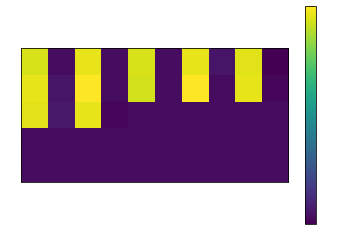

In [105]:
plt.imshow(grf_gpu.get())
plt.colorbar()

#### FFT via PyCuda Kernels (fails)

In [ ]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [ ]:
import numpy
a = numpy.random.randn(4,4)
a = a.astype(numpy.float32)

a_gpu = cuda.mem_alloc(a.nbytes)
cuda.memcpy_htod(a_gpu, a)

mod = SourceModule("""
  __global__ void doublify(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] *= 2;
  }
  """)
#Allocate,generateandtransfer
func = mod.get_function("doublify")
func(a_gpu, block=(4,4,1))

a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled,a_gpu)
print(a, "\n\n", a_doubled)

In [ ]:
kernel = gpu_ctx.get_kernel("fft.cu")

In [ ]:
func = kernel.get_function("doublify")

In [ ]:
func.prepare("f")

In [ ]:
func.prepared_async_call((4,4),(1,1,1),sim.gpu_stream, a)